# Ingest and View Data

In [1]:
import pandas as pd
from sqlalchemy import create_engine

In [2]:
POSTGRES_USERNAME = 'root'
POSTGRES_PASSWORD = 'koBREipm4h7CuRKix2Tn'
POSTGRES_HOSTNAME = 'database-1.c3ma8u2guxxs.us-east-2.rds.amazonaws.com'
POSTGRES_PORT = '5432'
POSTGRES_DBNAME = 'postgres'

connection_string = f"postgresql://{POSTGRES_USERNAME}:{POSTGRES_PASSWORD}@{POSTGRES_HOSTNAME}:{POSTGRES_PORT}/{POSTGRES_DBNAME}"
engine = create_engine(connection_string)

In [3]:
query = """
SELECT * FROM darwin
"""

df = pd.read_sql(query, engine)

In [4]:
df.head()

,route_id,unique_id,service_start_date,update_origin,train_platform,working_time_pass,working_time_arrival,working_time_departure,planned_time_arrival,planned_time_departure,...,platform,train_length,estimated_time,source,actual_time,actual_time_class,is_delayed_arrival,is_delayed_departure,source_instance,estimated_time_minutes
0,202407037139232,G39232,2024-07-03,TD,SCROYDN,None,19:31:00,19:31:30,19:31:00,19:31:00,...,4,10.0,None,None,None,None,False,False,None,None
1,202407036785172,C85172,2024-07-03,CIS,LIVSTLL,None,19:37:00,19:38:00,19:37:00,19:38:00,...,A,NaN,None,None,None,None,False,False,None,None
2,202407036735756,C35756,2024-07-03,TD,ESTHRAK,None,19:30:30,19:31:00,19:31:00,19:31:00,...,2,NaN,None,None,None,None,False,False,None,None
3,202407036735756,C35756,2024-07-03,TD,BRMB,None,19:33:00,19:33:30,19:33:00,19:33:00,...,1,NaN,None,None,None,None,False,False,None,None
4,202407036735756,C35756,2024-07-03,TD,BRMBRK,None,19:35:00,19:35:30,19:35:00,19:35:00,...,2,NaN,None,None,None,None,False,False,None,None


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 459801 entries, 0 to 459800
Data columns (total 22 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   route_id                459801 non-null  object 
 1   unique_id               459801 non-null  object 
 2   service_start_date      459801 non-null  object 
 3   update_origin           448288 non-null  object 
 4   train_platform          459801 non-null  object 
 5   working_time_pass       0 non-null       object 
 6   working_time_arrival    459801 non-null  object 
 7   working_time_departure  459801 non-null  object 
 8   planned_time_arrival    421333 non-null  object 
 9   planned_time_departure  419450 non-null  object 
 10  actual_arrival_time     386308 non-null  object 
 11  actual_departure_time   429044 non-null  object 
 12  platform                430382 non-null  object 
 13  train_length            147170 non-null  float64
 14  estimated_time      

# Clean DF 
**Drop Null Columns and Unnecessary Columns**

In [6]:
# columns to drop due to null values
columns_to_drop = [
    'working_time_pass',
    'estimated_time',
    'source',
    'actual_time',
    'actual_time_class',
    'source_instance',
    'estimated_time_minutes',
    'train_length'            
]

df_cleaned = df.drop(columns=columns_to_drop)

In [7]:
# check duplicates
duplicates = df_cleaned.duplicated().sum()
duplicates

15640

In [8]:
# to drop duplicates
df_cleaned = df_cleaned.drop_duplicates()

In [9]:
# check nulls
df_cleaned.isna().sum()

route_id                      0
unique_id                     0
service_start_date            0
update_origin             10153
train_platform                0
working_time_arrival          0
working_time_departure        0
planned_time_arrival      38121
planned_time_departure    39580
actual_arrival_time       73215
actual_departure_time     30220
platform                  28732
is_delayed_arrival            0
is_delayed_departure          0
dtype: int64

In [10]:
# to drop remaining nulls
# df_cleaned = df_cleaned.dropna()

# Create Delay DF

In [11]:
query_delay = "SELECT * FROM darwin WHERE is_delayed_arrival = True AND is_delayed_departure = True"
df_delay = pd.read_sql(query_delay, engine)

In [12]:
df_delay = df_delay.drop(columns=columns_to_drop)

In [13]:
df_delay.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56987 entries, 0 to 56986
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   route_id                56987 non-null  object
 1   unique_id               56987 non-null  object
 2   service_start_date      56987 non-null  object
 3   update_origin           56967 non-null  object
 4   train_platform          56987 non-null  object
 5   working_time_arrival    56987 non-null  object
 6   working_time_departure  56987 non-null  object
 7   planned_time_arrival    32788 non-null  object
 8   planned_time_departure  32591 non-null  object
 9   actual_arrival_time     56955 non-null  object
 10  actual_departure_time   56758 non-null  object
 11  platform                43286 non-null  object
 12  is_delayed_arrival      56987 non-null  bool  
 13  is_delayed_departure    56987 non-null  bool  
dtypes: bool(2), object(12)
memory usage: 5.3+ MB


In [14]:
df_delay.duplicated().sum()

293

# Adding Duration Column
Convert times from object datatypes to time datatypes.

In [15]:
df_cleaned['working_time_arrival'] = pd.to_datetime(df_cleaned['working_time_arrival'], format='%H:%M:%S')
df_cleaned['working_time_departure'] = pd.to_datetime(df_cleaned['working_time_departure'], format='%H:%M:%S')

Complete math to find duration.

In [16]:
df_cleaned['duration (min)'] = ((df_cleaned['working_time_departure']-df_cleaned['working_time_arrival'])\
                                .dt.total_seconds()/60)

Transition back to time only.

In [17]:
df_cleaned['working_time_arrival'] = df_cleaned['working_time_arrival'].dt.time
df_cleaned['working_time_departure'] = df_cleaned['working_time_departure'].dt.time

Repeat for Delay Dataframe.

In [18]:
df_delay['working_time_arrival'] = pd.to_datetime(df_delay['working_time_arrival'], format='%H:%M:%S')
df_delay['working_time_departure'] = pd.to_datetime(df_delay['working_time_departure'], format='%H:%M:%S')
df_delay['duration (min)'] = ((df_delay['working_time_departure']-df_delay['working_time_arrival'])\
                                .dt.total_seconds()/60)
df_delay['working_time_arrival'] = df_delay['working_time_arrival'].dt.time
df_delay['working_time_departure'] = df_delay['working_time_departure'].dt.time

In [19]:
# Check for zero and negative values
neg_zero_duration_counts = df_cleaned[df_cleaned['duration (min)'] <= 0]['duration (min)'].value_counts().sort_index(ascending=True)

# Display the result
print(neg_zero_duration_counts)

duration (min)
-1438.5      13
-1438.0      23
-1437.5       9
-1437.0      46
-1436.5       1
-1436.0      64
-1435.0      26
-1434.5       2
-1434.0      43
-1433.5       1
-1433.0      22
-1432.0      34
-1431.5       7
-1431.0      25
-1430.5       1
-1430.0      68
-1429.5       2
-1429.0       1
-1428.0       3
-1427.0       8
-1426.0       1
-1423.0       8
-1421.0       1
-1420.0       3
-1419.0       8
-1418.0       4
-1417.5       4
-1416.0       1
-1413.0       6
-1407.0       6
-1406.5       6
-1406.0       1
-1402.0       1
-1401.0      20
-1395.0       8
-1392.0       4
-1352.0       4
-1351.0       1
-1320.0       1
-1313.5      12
-1310.5       1
-1309.0       1
-1303.0       2
-1272.5       2
 0.0       7886
Name: count, dtype: int64


In [20]:
# Drop the rows with negative values in duration
df_cleaned = df_cleaned[df_cleaned['duration (min)'] > 0]

In [21]:
# Check
neg_zero_duration_counts = df_cleaned[df_cleaned['duration (min)'] <= 0]['duration (min)'].value_counts().sort_index(ascending=True)

# Display the result
print(neg_zero_duration_counts)

Series([], Name: count, dtype: int64)


In [22]:
# Repeating Drop for delay_df to remove negative values in duration

df_delay = df_delay[df_delay['duration (min)'] > 0]

# Ingest Rail References Data

In [23]:
reference_df = pd.read_csv('./raw_data/RailReferences.csv')

## Convert Easting, Northing to Latitude and Longitude

In [24]:
!pip install pyproj

In [25]:
from pyproj import Transformer

In [26]:
#  Define the British National Grid projection (EPSG:27700) and WGS84
osgb_projection = 'epsg:27700'  # British National Grid
wgs84_projection = 'epsg:4326'  # WGS84

In [27]:
# Initialize the transformer
transformer = Transformer.from_crs(osgb_projection, wgs84_projection)

In [28]:
# Function to convert British National Grid to latitude and longitude
def convert_osgb_to_latlong(easting, northing):
    longitude, latitude = transformer.transform(easting, northing)
    return longitude, latitude

In [29]:
# Apply conversion to the DataFrame and create new columns Latitude and Longitude
reference_df[['Latitude', 'Longitude']] = reference_df.apply(lambda row: convert_osgb_to_latlong(row['Easting'], row['Northing']),\
                                         axis=1,\
                                         result_type='expand')

In [30]:
# Data need for analysis 
data = reference_df[['TiplocCode', 'StationName', 'Latitude', 'Longitude']]
data

,TiplocCode,StationName,Latitude,Longitude
0,PENZNCE,Penzance Rail Station,50.121672,-5.532565
1,STIVES,St Ives (Cornwall) Rail Station,50.209043,-5.477912
2,CARBISB,Carbis Bay Rail Station,50.197048,-5.463263
3,STERTH,St Erth Rail Station,50.170489,-5.444252
4,LELANTS,Lelant Saltings Rail Station,50.178775,-5.440926
...,...,...,...,...
2623,SMRLYTN,Somerleyton Rail Station,52.510229,1.652260
2624,OULTNBS,Oulton Broad South Rail Station,52.469602,1.707659
2625,YARMTH,Great Yarmouth Rail Station,52.612158,1.720886
2626,OULTNBN,Oulton Broad North Rail Station,52.477759,1.715711


### Data Enrichment
Used this section to add identifying information for top Timing Point Locations (*TiplocCode*) not already identified in the supplied "RailReferences.csv" data. 

Research indicates that the Timing Point Location for BONDST, correlates to Bond Street Station$^{1}$ located at 51.514°N, 0.15°W$^{2}$. 

In [31]:
new_row = pd.DataFrame([['BONDST', 'Bond Street Station', 51.514, -0.15]], columns=data.columns)
data = pd.concat([data, new_row], ignore_index=True)

Research indicates that the Timing Point Location for TOTCTRD, correlates to Tottenham Court Road$^{1}$ located at 51.5207°N, 0.1345°W$^{3}$. 

In [32]:
new_row = pd.DataFrame([['TOTCTRD', 'Tottenham Court Road', 51.5207, -0.1345]], columns=data.columns)
data = pd.concat([data, new_row], ignore_index=True)

Research indicates that the Timing Point Location for CANWHRF, correlates to Canary Wharf Railway Station$^{1}$ located at 51.5061°N, 0.01578°W$^{4}$. 

In [33]:
new_row = pd.DataFrame([['CANWHRF', 'Canary Wharf Railway Station', 51.5061, -0.01578]], columns=data.columns)
data = pd.concat([data, new_row], ignore_index=True)

Research indicates that the Timing Point Location for WCHAPXR, correlates to Whitechapel Crossrail$^{1}$ located at 51.5195°N, 0.0612°W$^{5, 6}$. 

In [34]:
new_row = pd.DataFrame([['WCHAPXR', 'Whitechapel Crossrail', 51.9195, -0.0612]], columns=data.columns)
data = pd.concat([data, new_row], ignore_index=True)

Research indicates that the Timing Point Location for LIVSTLL, correlates to London Liverpool Street Crossrail$^{1}$ located at 51.5186°N, 0.0813°W$^{6, 7}$. 

In [35]:
new_row = pd.DataFrame([['LIVSTLL', 'London Liverpool Street Crossrail', 51.5186, -0.0813]], columns=data.columns)
data = pd.concat([data, new_row], ignore_index=True)

### Bibliography

1. http://www.railwaycodes.org.uk/crs/crsb.shtm

2. https://en.wikipedia.org/wiki/Bond_Street_station

3. https://en.wikipedia.org/wiki/Tottenham_Court_Road

4. https://en.wikipedia.org/wiki/Canary_Wharf_railway_station

5. https://en.wikipedia.org/wiki/Whitechapel_station

6. https://en.wikipedia.org/wiki/Crossrail

7. https://en.wikipedia.org/wiki/Liverpool_Street_station

## Using Rail References to Replace Train Platform with Station Name

In [36]:
# Merge df_cleaned with data columns from reference_df

df_merged = df_cleaned.merge(data, left_on='train_platform', right_on='TiplocCode', how='left')

In [37]:
# checking where train_platform has no related StationName/Tiploccode
nan_rows = df_merged[df_merged[['TiplocCode', 'StationName']].isna().any(axis=1)]

nan_rows[['train_platform', 'TiplocCode', 'StationName']]

,train_platform,TiplocCode,StationName
16,WOLWXR,NaN,NaN
23,FRMPKRS,NaN,NaN
24,HRNS451,NaN,NaN
25,BOWERRL,NaN,NaN
52,CMRNBDG,NaN,NaN
...,...,...,...
435567,CUSTMHS,NaN,NaN
435568,WOLWXR,NaN,NaN
435707,OXEN45,NaN,NaN
435758,LTLH11,NaN,NaN


In [38]:
# Identifying most highly frequented unknown Station Names
station_NaN = df_merged[df_merged['StationName'].isna()]['train_platform'].value_counts()
station_NaN.head(20)

train_platform
FRNDXR     1177
PADTLL      751
CUSTMHS     675
WOLWXR      646
BRENTX      489
STALBCS     432
MAGHNTH     378
MLLF        314
PALL        309
CIVI        297
STDI        292
BOWERRL     289
UNIV        289
SHLDNO1     282
CHST528     266
FELL        264
EBSFLTI     244
CNNBELL     227
STFORDI     218
MNTGLCW     213
Name: count, dtype: int64

In [39]:
# fill NaN values in the StationName column with the corresponding train_platform values
df_merged['StationName'] = df_merged['StationName'].fillna(df_merged['train_platform'])

# Replace 'Rail Station' with an empty string to make more readable
df_merged['StationName'] = df_merged['StationName'].str.replace(' Rail Station', '')

In [40]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435770 entries, 0 to 435769
Data columns (total 19 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   route_id                435770 non-null  object 
 1   unique_id               435770 non-null  object 
 2   service_start_date      435770 non-null  object 
 3   update_origin           425682 non-null  object 
 4   train_platform          435770 non-null  object 
 5   working_time_arrival    435770 non-null  object 
 6   working_time_departure  435770 non-null  object 
 7   planned_time_arrival    401089 non-null  object 
 8   planned_time_departure  399618 non-null  object 
 9   actual_arrival_time     363318 non-null  object 
 10  actual_departure_time   405770 non-null  object 
 11  platform                412104 non-null  object 
 12  is_delayed_arrival      435770 non-null  bool   
 13  is_delayed_departure    435770 non-null  bool   
 14  duration (min)      

## Adding a Day of the Wek Column

# Delays

In [41]:
df_delay = df_delay.merge(data, left_on='train_platform', right_on='TiplocCode', how='left')

In [42]:
# fill NaN values in the StationName column with the corresponding train_platform values
df_delay['StationName'] = df_delay['StationName'].fillna(df_delay['train_platform'])

# Replace 'Rail Station' with an empty string to make more readable
df_delay['StationName'] = df_delay['StationName'].str.replace(' Rail Station', '')

In [43]:
df_delay.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54127 entries, 0 to 54126
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   route_id                54127 non-null  object 
 1   unique_id               54127 non-null  object 
 2   service_start_date      54127 non-null  object 
 3   update_origin           54107 non-null  object 
 4   train_platform          54127 non-null  object 
 5   working_time_arrival    54127 non-null  object 
 6   working_time_departure  54127 non-null  object 
 7   planned_time_arrival    31719 non-null  object 
 8   planned_time_departure  31522 non-null  object 
 9   actual_arrival_time     54095 non-null  object 
 10  actual_departure_time   53898 non-null  object 
 11  platform                42269 non-null  object 
 12  is_delayed_arrival      54127 non-null  bool   
 13  is_delayed_departure    54127 non-null  bool   
 14  duration (min)          54127 non-null

Determine the minutes delayed.

In [44]:
df_delay['working_time_arrival'] = pd.to_datetime(df_delay['working_time_arrival'], format='%H:%M:%S')
df_delay['working_time_departure'] = pd.to_datetime(df_delay['working_time_departure'], format='%H:%M:%S')
df_delay['duration (min)'] = ((df_delay['working_time_departure']-df_delay['working_time_arrival'])\
                                .dt.total_seconds()/60)

In [45]:
df_delay['actual_arrival_time'] = pd.to_datetime(df_delay['actual_arrival_time'], format='%H:%M:%S')
df_delay['actual_departure_time'] = pd.to_datetime(df_delay['actual_departure_time'], format='%H:%M:%S')

In [46]:
df_delay['depart_delay(min)'] = ((df_delay['actual_departure_time']-df_delay['working_time_departure'])\
                                .dt.total_seconds()/60)

In [47]:
df_delay['arrive_delay(min)'] = ((df_delay['actual_arrival_time']-df_delay['working_time_arrival'])\
                                .dt.total_seconds()/60)

In [48]:
df_delay['working_time_arrival'] = df_delay['working_time_arrival'].dt.time
df_delay['working_time_departure'] = df_delay['working_time_departure'].dt.time
df_delay['actual_arrival_time'] = df_delay['actual_arrival_time'].dt.time
df_delay['actual_departure_time'] = df_delay['actual_departure_time'].dt.time

In [49]:
df_delay.describe()

,duration (min),Latitude,Longitude,depart_delay(min),arrive_delay(min)
count,54127.000000,43366.000000,43366.000000,53898.000000,54095.000000
mean,3.138970,52.201418,-1.277390,-58.469088,-55.972823
std,7.826806,1.230098,1.393257,367.584603,367.522074
min,0.100000,50.170489,-5.444252,-1439.000000,-1436.500000
25%,0.500000,51.530539,-2.562430,5.000000,6.000000
50%,1.000000,51.570212,-0.458503,26.000000,28.000000
75%,3.000000,52.754376,-0.243268,68.500000,70.500000
max,247.000000,57.188510,1.715711,1434.000000,1438.000000


We can see that the math in the previous step created some erroneous values (minimum of depart_delay(min) is negative.) This will occur in cases where there is no reported actual_departure_time. We will get the value zero where the train is not delayed. We will define a function to remove delays less than or equal to zero.

In [50]:
def remove_neg_and_zero(delay):
    if delay <= 0:
        delay = None
    else:
        delay = delay
    return delay

In [51]:
df_delay['depart_delay(min)'] = df_delay['depart_delay(min)'].apply(remove_neg_and_zero)
df_delay['arrive_delay(min)'] = df_delay['arrive_delay(min)'].apply(remove_neg_and_zero)

In [52]:
df_delay.describe()

,duration (min),Latitude,Longitude,depart_delay(min),arrive_delay(min)
count,54127.000000,43366.000000,43366.000000,45117.000000,47640.000000
mean,3.138970,52.201418,-1.277390,49.109018,48.724016
std,7.826806,1.230098,1.393257,57.220014,57.753590
min,0.100000,50.170489,-5.444252,0.500000,0.500000
25%,0.500000,51.530539,-2.562430,12.000000,11.000000
50%,1.000000,51.570212,-0.458503,38.000000,37.000000
75%,3.000000,52.754376,-0.243268,76.000000,76.000000
max,247.000000,57.188510,1.715711,1434.000000,1438.000000


We can see that the are some erroneous high values for depart_delay(min) and arrive_delay(min). We will remove any values over 420minutes (7hrs), assuming those trains are rescheduled rather than delayed.

In [53]:
def remove_over_420(delay):
    if delay > 420:
        delay = None
    else:
        delay = delay
    return delay

In [54]:
df_delay['depart_delay(min)'] = df_delay['depart_delay(min)'].apply(remove_over_420)
df_delay['arrive_delay(min)'] = df_delay['arrive_delay(min)'].apply(remove_over_420)

In [55]:
df_delay.describe()

,duration (min),Latitude,Longitude,depart_delay(min),arrive_delay(min)
count,54127.000000,43366.000000,43366.000000,45076.000000,47597.000000
mean,3.138970,52.201418,-1.277390,47.903354,47.518155
std,7.826806,1.230098,1.393257,40.940787,41.546850
min,0.100000,50.170489,-5.444252,0.500000,0.500000
25%,0.500000,51.530539,-2.562430,12.000000,11.000000
50%,1.000000,51.570212,-0.458503,38.000000,37.000000
75%,3.000000,52.754376,-0.243268,76.000000,76.000000
max,247.000000,57.188510,1.715711,257.500000,257.000000


In [56]:
df_delay.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54127 entries, 0 to 54126
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   route_id                54127 non-null  object 
 1   unique_id               54127 non-null  object 
 2   service_start_date      54127 non-null  object 
 3   update_origin           54107 non-null  object 
 4   train_platform          54127 non-null  object 
 5   working_time_arrival    54127 non-null  object 
 6   working_time_departure  54127 non-null  object 
 7   planned_time_arrival    31719 non-null  object 
 8   planned_time_departure  31522 non-null  object 
 9   actual_arrival_time     54095 non-null  object 
 10  actual_departure_time   53898 non-null  object 
 11  platform                42269 non-null  object 
 12  is_delayed_arrival      54127 non-null  bool   
 13  is_delayed_departure    54127 non-null  bool   
 14  duration (min)          54127 non-null

In [57]:
# export delay routes csv
df_delay.to_csv('./cleaned_data/delay_durations.csv', index=False, mode = 'w+')

## Calculate Delay Duration
Take the data where we are able to calucate delays.

In [58]:
df_delay.head()

,route_id,unique_id,service_start_date,update_origin,train_platform,working_time_arrival,working_time_departure,planned_time_arrival,planned_time_departure,actual_arrival_time,...,platform,is_delayed_arrival,is_delayed_departure,duration (min),TiplocCode,StationName,Latitude,Longitude,depart_delay(min),arrive_delay(min)
0,202407037144581,G44581,2024-07-03,Darwin,GLOSTER,19:22:00,19:28:00,19:21:00,19:28:00,19:32:00,...,1,True,True,6.0,GLOSTER,Gloucester,51.865557,-2.238488,5.0,10.0
1,202407036707715,C07715,2024-07-03,Darwin,LADYBHL,19:24:00,19:35:30,None,None,19:33:00,...,None,True,True,11.5,NaN,LADYBHL,NaN,NaN,NaN,9.0
2,202407037154103,G54103,2024-07-03,Darwin,CRAWLEY,19:26:30,19:27:30,19:27:00,19:27:00,19:35:00,...,2,True,True,1.0,CRAWLEY,Crawley,51.112212,-0.186673,7.5,8.5
3,202407037154103,G54103,2024-07-03,Darwin,IFIELD,19:29:30,19:30:00,19:30:00,19:30:00,19:37:00,...,2,True,True,0.5,IFIELD,Ifield,51.115621,-0.214772,8.0,7.5
4,202407037154103,G54103,2024-07-03,Darwin,FAYGATE,19:33:30,19:34:00,19:34:00,19:34:00,19:41:00,...,2,True,True,0.5,FAYGATE,Faygate,51.095889,-0.263019,8.0,7.5


In [59]:
# Create the 'delayed' column
df_merged['delayed'] = df_merged['is_delayed_arrival'] | df_merged['is_delayed_departure']
df_merged['delayed'] = df_merged['delayed'].astype(int)

# Check
df_merged.head()

,route_id,unique_id,service_start_date,update_origin,train_platform,working_time_arrival,working_time_departure,planned_time_arrival,planned_time_departure,actual_arrival_time,actual_departure_time,platform,is_delayed_arrival,is_delayed_departure,duration (min),TiplocCode,StationName,Latitude,Longitude,delayed
0,202407037139232,G39232,2024-07-03,TD,SCROYDN,19:31:00,19:31:30,19:31:00,19:31:00,None,19:32:00,4,False,False,0.5,SCROYDN,South Croydon,51.362963,-0.093457,0
1,202407036785172,C85172,2024-07-03,CIS,LIVSTLL,19:37:00,19:38:00,19:37:00,19:38:00,19:37:00,19:38:00,A,False,False,1.0,LIVSTLL,London Liverpool Street Crossrail,51.518600,-0.081300,0
2,202407036735756,C35756,2024-07-03,TD,ESTHRAK,19:30:30,19:31:00,19:31:00,19:31:00,None,None,2,False,False,0.5,ESTHRAK,Eastham Rake,53.307537,-2.981132,0
3,202407036735756,C35756,2024-07-03,TD,BRMB,19:33:00,19:33:30,19:33:00,19:33:00,19:33:00,19:33:00,1,False,False,0.5,BRMB,Bromborough,53.321845,-2.986895,0
4,202407036735756,C35756,2024-07-03,TD,BRMBRK,19:35:00,19:35:30,19:35:00,19:35:00,19:35:00,19:35:00,2,False,False,0.5,BRMBRK,Bromborough Rake,53.329905,-2.989469,0


## Delays  by Route

In [60]:
# Extract the necessary columns
df_extracted = df_merged[['route_id', 'delayed']]

# Calculate the count of delays for each route_id and TiplocCode
delay_counts_by_route = df_extracted.groupby('route_id')['delayed'].sum().reset_index()
delay_counts_by_route.rename(columns={'delayed': 'delay_counts_by_route'}, inplace=True)

# Calculate the total count of records for each route_id and TiplocCode
total_counts_by_route = df_extracted.groupby('route_id')['route_id'].count().reset_index(name='total_counts_by_route')

# Merge the delay counts and total counts
delay_summary = delay_counts_by_route.merge(total_counts_by_route, on='route_id')

# Calculate the % delayed for each route_id
delay_summary['%_delayed_by_route'] = (delay_summary['delay_counts_by_route'] / delay_summary['total_counts_by_route']) * 100

# Select the relevant columns
delays_by_route = delay_summary[['route_id', 'delay_counts_by_route', 'total_counts_by_route', '%_delayed_by_route']]

# Check
delays_by_route

,route_id,delay_counts_by_route,total_counts_by_route,%_delayed_by_route
0,202407036704095,0,1,0.0
1,202407036704542,0,1,0.0
2,202407036705093,1,5,20.0
3,202407036705096,0,6,0.0
4,202407036705102,0,5,0.0
...,...,...,...,...
86964,202407158904586,0,2,0.0
86965,202407158904686,0,1,0.0
86966,202407158905794,0,4,0.0
86967,202407166705074,0,8,0.0


In [61]:
# export delay routes csv
delays_route = delays_by_route.to_csv('./cleaned_data/delays_by_route.csv', index=False, mode = 'w+')

## Delays by Station Name

Changed to aggregate by TiplocCode, because upon further investigation it was found that a Station Name may have various TiplocCodes. Which would inflate the delay counts and station counts for each individual TiplocCode

In [62]:
df_extracted2 = df_merged[['StationName', 'TiplocCode', 'delayed', 'Latitude', 'Longitude']]

# Calculate the count of delays for each TiplocCode
delay_counts_by_tiploc = df_extracted2.groupby('TiplocCode')['delayed'].sum().reset_index()
delay_counts_by_tiploc.rename(columns={'delayed': 'delay_counts_by_tiploc'}, inplace=True)

# Calculate the total count of records for each TiplocCode
total_counts_by_tiploc = df_extracted2.groupby('TiplocCode')['TiplocCode'].count().reset_index(name='total_counts_by_tiploc')

# Merge the delay counts and total counts
delay_summary_tiploc = delay_counts_by_tiploc.merge(total_counts_by_tiploc, on='TiplocCode')

# Calculate the % delayed for each TiplocCode
delay_summary_tiploc['%_delayed_by_tiploc'] = (delay_summary_tiploc['delay_counts_by_tiploc'] / delay_summary_tiploc['total_counts_by_tiploc']) * 100

# Select the relevant columns
delays_by_tiploc = delay_summary_tiploc[['TiplocCode', 'delay_counts_by_tiploc', 'total_counts_by_tiploc', '%_delayed_by_tiploc']]

# Merge the dataframes on 'TiplocCode' to add latitude, longitude, and StationName
delays_by_tiploc = pd.merge(delays_by_tiploc, df_extracted2[['TiplocCode', 'StationName', 'Latitude', 'Longitude']].drop_duplicates(), on='TiplocCode', how='left')

# Check
delays_by_tiploc[delays_by_tiploc['StationName'] == 'Clapham Junction']

,TiplocCode,delay_counts_by_tiploc,total_counts_by_tiploc,%_delayed_by_tiploc,StationName,Latitude,Longitude
494,CLPHMJC,73,1339,5.451830,Clapham Junction,51.464186,-0.170279
495,CLPHMJM,52,1281,4.059329,Clapham Junction,51.464186,-0.170265
496,CLPHMJW,24,694,3.458213,Clapham Junction,51.464186,-0.170250


In [63]:
# exporting delays by station to csv
delay_stations = delays_by_tiploc.to_csv('./cleaned_data/delays_by_station.csv', index=False, mode = 'w+')

In [64]:
# check how is_delayed arrivals/departures compare with delayed column
df_merged['is_delayed_arrival'].value_counts()

is_delayed_arrival
False    381935
True      53835
Name: count, dtype: int64

In [65]:
df_merged['is_delayed_departure'].value_counts()

is_delayed_departure
False    379856
True      55914
Name: count, dtype: int64

In [66]:
df_merged['delayed'].value_counts()

delayed
0    379856
1     55914
Name: count, dtype: int64

Delayed column has same counts as is_delayed_departure. 

# Value Counts for Analysis 

In [67]:
df_merged['service_start_date'].value_counts()

service_start_date
2024-07-12    72020
2024-07-11    65224
2024-07-13    63519
2024-07-14    58702
2024-07-10    41466
2024-07-09    35853
2024-07-15    30304
2024-07-05    24449
2024-07-04    12000
2024-07-08    11222
2024-07-06     9804
2024-07-07     7710
2024-07-03     3475
2024-07-16       22
Name: count, dtype: int64

In [68]:
# most popular routes
df_merged['route_id'].value_counts()

route_id
202407158332472    273
202407158332474    205
202407148085175    185
202407148085184    141
202407137950909    122
                  ... 
202407107112986      1
202407137639838      1
202407136761215      1
202407107139226      1
202407157661766      1
Name: count, Length: 86969, dtype: int64

In [69]:
df_merged['StationName'].value_counts()

StationName
Clapham Junction                3314
London Bridge                   2840
Willesden Junction Low Level    2822
Harlesden                       2508
East Croydon                    2060
                                ... 
EXHIBDS                            1
NTNFTZN                            1
CARLLRJ                            1
BLEMOR                             1
ELGH241                            1
Name: count, Length: 3122, dtype: int64

# Visuals 

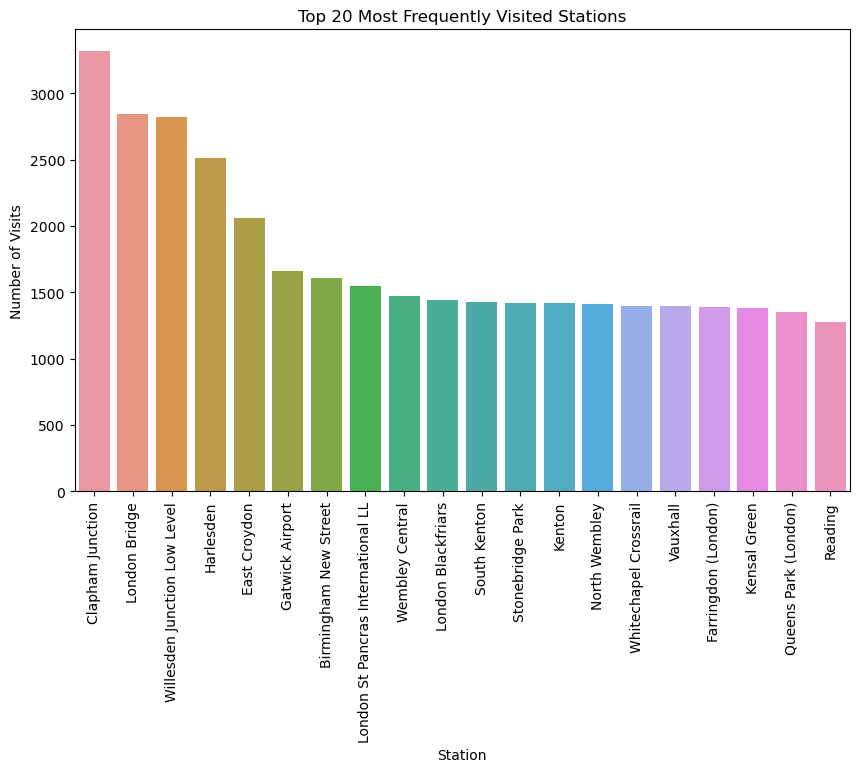

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
# Top 10 most frequently visited stations
top_stations = df_merged['StationName'].value_counts().head(20)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_stations.index, y=top_stations.values)
plt.title('Top 20 Most Frequently Visited Stations')
plt.xlabel('Station')
plt.ylabel('Number of Visits')
plt.xticks(rotation=90)
plt.show()

The chart shows the top 20 most frequently visited stations in the UK rail system, revealing that 13 of these stations are in London. This highlights London's central role in the rail network, driven by its approximate population of 9 million, which constitutes about 13% of the UK's total population. Major hubs like Clapham Junction and London Bridge, as well as key interchange points and commuter stations, contribute to this high traffic, reflecting the substantial demand generated by the city's large population.

Additionally, the chart underscores the importance of regional hubs such as Birmingham New Street, York, and Reading, which serve as central points for their areas, and the significance of rail connections to major airports like Gatwick. The presence of stations like City Thameslink and Whitechapel Crossrail also highlights the integration of various transport modes, providing seamless connectivity for passengers. Overall, London's dominance in the list illustrates its pivotal role in the UK's rail system, driven by its large population and economic activity.

## Duration Distribution 

In [71]:
df_merged.describe()

,duration (min),Latitude,Longitude,delayed
count,435770.000000,413630.000000,413630.000000,435770.000000
mean,1.497650,52.203617,-1.138204,0.128311
std,3.604377,1.337416,1.428278,0.334436
min,0.050000,50.121672,-5.839077,0.000000
25%,0.500000,51.431663,-2.180987,0.000000
50%,1.000000,51.549430,-0.395881,0.000000
75%,1.000000,52.916546,-0.092780,0.000000
max,247.000000,58.590175,1.715711,1.000000


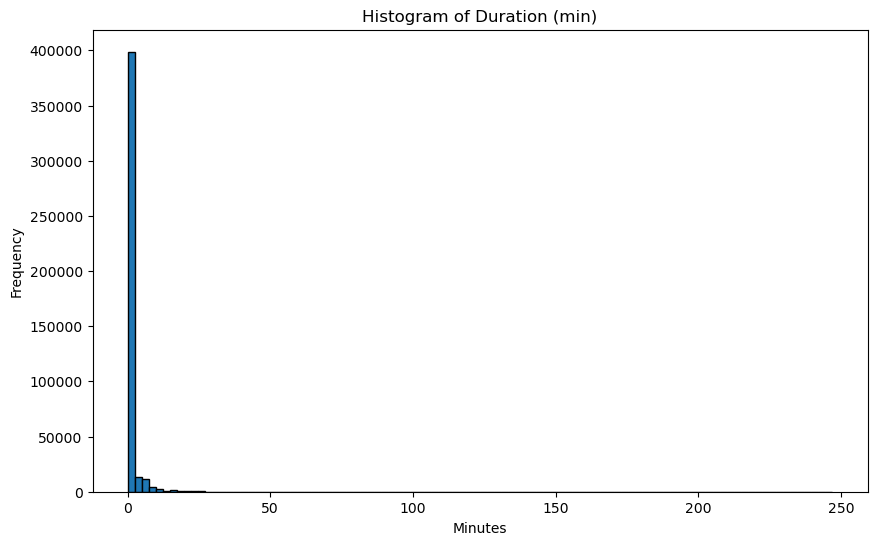

In [72]:
# Histogram for 'duration (min)'
plt.figure(figsize=(10, 6))
plt.hist(df_merged['duration (min)'], bins=100, edgecolor='black')
plt.title('Histogram of Duration (min)')
plt.xlabel('Minutes')
plt.ylabel('Frequency')
plt.show()

Showing true 

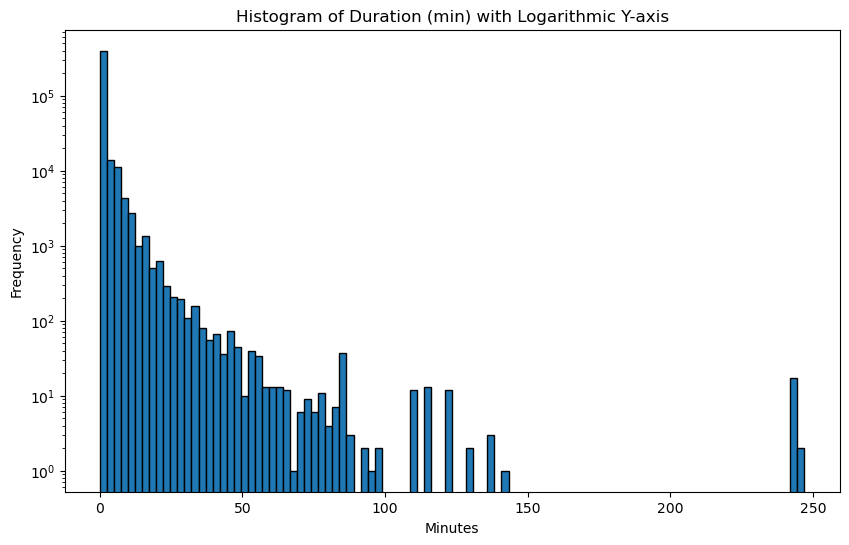

In [73]:
# Histogram for 'duration (min)' with smaller bins and logarithmic x-axis
plt.figure(figsize=(10, 6))
plt.hist(df_merged['duration (min)'], bins=100, edgecolor='black', log=True)

plt.title('Histogram of Duration (min) with Logarithmic Y-axis')
plt.xlabel('Minutes')
plt.ylabel('Frequency')
plt.yscale('log')
plt.show()

This histogram shows the distribution of trip durations from station to station with a logarithmic y-axis. The logarithmic scale is used to make it easier to see and understand data that has a very wide range by squeezing the numbers into a smaller, more readable format. The histogram reveals a high frequency of short trips, with the majority of trip durations clustered around the lower end, particularly between 0 and 50 minutes. There are significant drops in frequency as the duration increases, indicating that long trips are much less common. A few peaks at higher durations suggest some outliers where trips are unusually long.

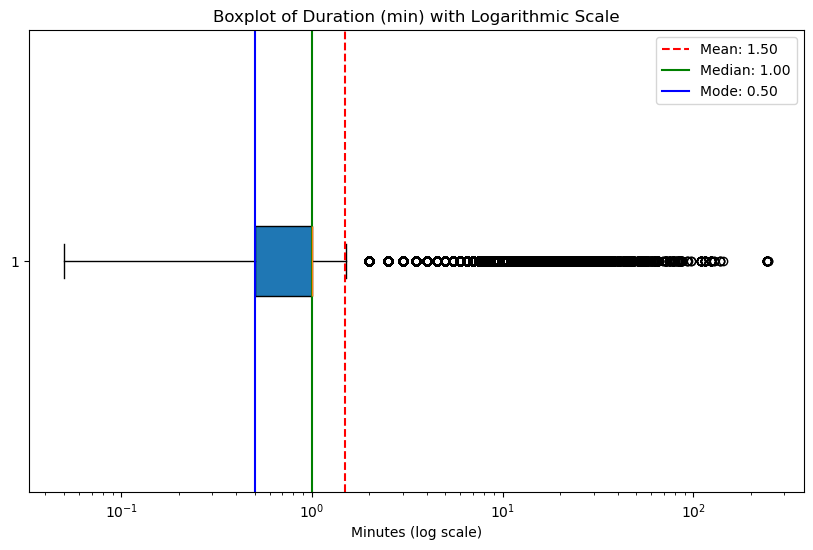

In [74]:
# Boxplot for 'duration (min)' with a logarithmic scale
plt.figure(figsize=(10, 6))
plt.boxplot(df_merged['duration (min)'], vert=False, patch_artist=True, showfliers=True)
plt.xscale('log')

# Add mean and median lines
mean_duration = df_merged['duration (min)'].mean()
median_duration = df_merged['duration (min)'].median()
mode_duration = df_merged['duration (min)'].mode().iloc[0]

plt.axvline(mean_duration, color='r', linestyle='--', label=f'Mean: {mean_duration:.2f}')
plt.axvline(median_duration, color='g', linestyle='-', label=f'Median: {median_duration:.2f}')
plt.axvline(mode_duration, color='b', linestyle='-', label=f'Mode: {mode_duration:.2f}')

plt.title('Boxplot of Duration (min) with Logarithmic Scale')
plt.xlabel('Minutes (log scale)')
plt.legend()
plt.show()

This boxplot provides a detailed summary of the distribution, highlighting the mean, median, and mode durations. The median trip duration is 1 minute, with a mean slightly higher at 1.48 minutes, indicating that the distribution is right-skewed with a long tail of longer durations. The mode is at 0.50 minutes, showing that very short trips are most common. The presence of numerous outliers further supports the observation from the histogram that while most trips are short, there are occasional long trips that are significantly longer than the majority. The logarithmic scale on the x-axis helps to spread out the data points, making it easier to see the distribution and identify the concentration of shorter trips and the spread of longer ones.

### Overall Analysis on Trip Duration Distribution. 

The analysis of trip durations reveals that the majority of trips are very short, with most durations clustered between 0 and 50 minutes. This trend makes sense given that the majority of trips occur in densely populated cities like London, where stations are closely spaced, and the demand for frequent, short commutes is high. In such urban environments, the transportation network is designed to handle large volumes of passengers moving over short distances, facilitating quick and efficient travel between closely situated stations.

In cities like London, people often rely on the rail system for daily commutes, errands, and short-distance travel, contributing to the high frequency of brief trips. The shorter trips are reflective of the urban layout, where stations are strategically placed to maximize accessibility and convenience for city dwellers. The presence of numerous outliers with longer trip durations indicates occasional longer journeys, but these are less common. Overall, the data aligns with the expected travel patterns in a densely populated metropolitan area, emphasizing the importance of the rail network in supporting urban mobility.

## Delay Distributions

C:\Users\jules_7owst96\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\jules_7owst96\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


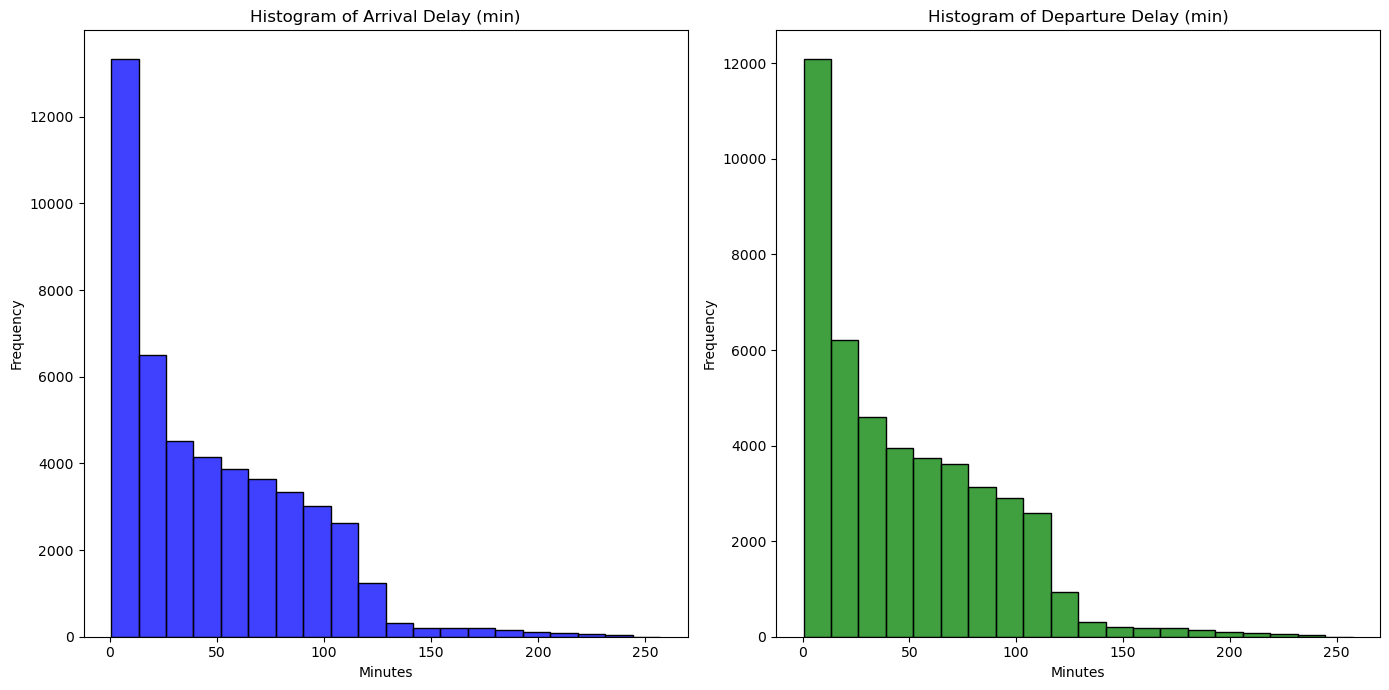

In [75]:
plt.figure(figsize=(14, 7))

# Arrival delay histogram
plt.subplot(1, 2, 1)
sns.histplot(df_delay['arrive_delay(min)'], bins=20, color='blue')
plt.title('Histogram of Arrival Delay (min)')
plt.xlabel('Minutes')
plt.ylabel('Frequency')

# Departure delay histogram
plt.subplot(1, 2, 2)
sns.histplot(df_delay['depart_delay(min)'], bins=20, color='green')
plt.title('Histogram of Departure Delay (min)')
plt.xlabel('Minutes')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

The histograms display a high frequency of shorter delays, with most clustered between 0 and 50 minutes. As delay time increases, the frequency decreases, indicating that longer delays are less common. This right-skewed distribution shows that while shorter delays are frequent, longer delays, though less common, do occur.

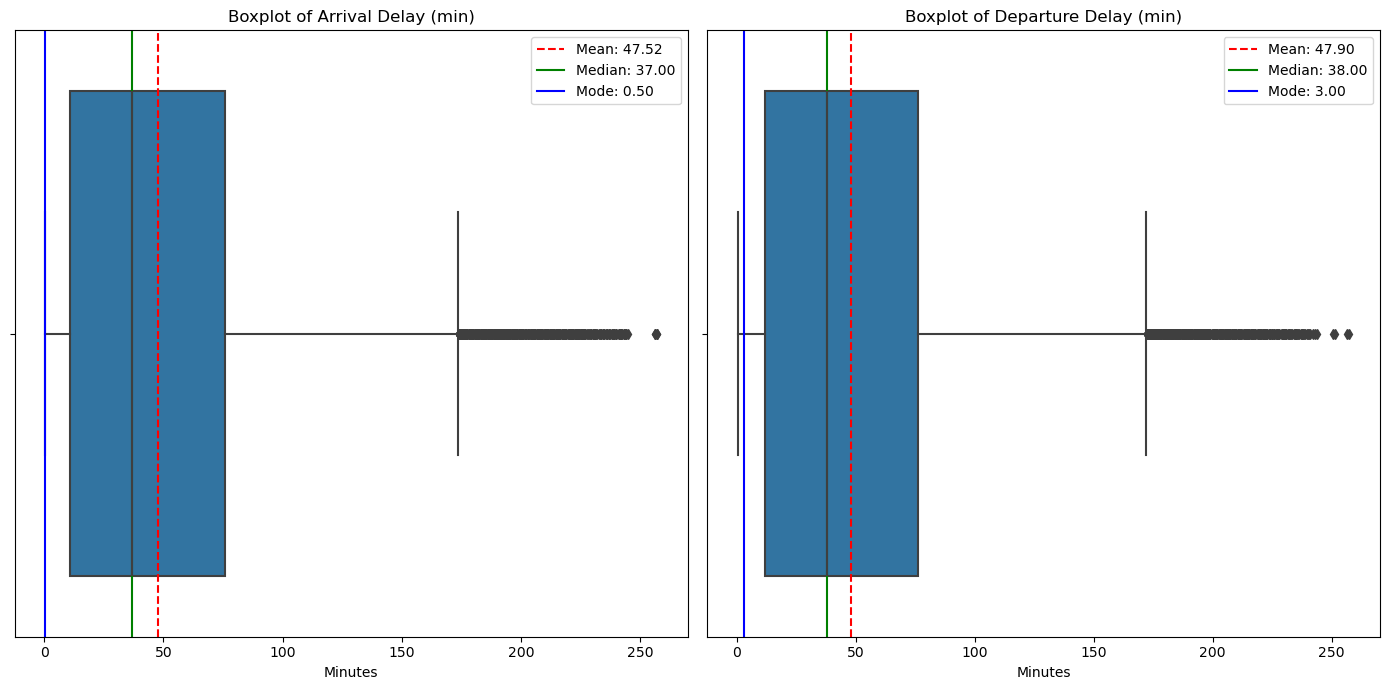

In [76]:
# Plot boxplot for arrival_delay and depart_delay
plt.figure(figsize=(14, 7))

# Adding mode 
arrival_mode = df_delay['arrive_delay(min)'].mode().iloc[0]
depart_mode = df_delay['depart_delay(min)'].mode().iloc[0]

# Arrival delay boxplot
plt.subplot(1, 2, 1)
sns.boxplot(x=df_delay['arrive_delay(min)'])
plt.title('Boxplot of Arrival Delay (min)')
plt.xlabel('Minutes')
plt.axvline(df_delay['arrive_delay(min)'].mean(), color='red', linestyle='--', label=f'Mean: {df_delay["arrive_delay(min)"].mean():.2f}')
plt.axvline(df_delay['arrive_delay(min)'].median(), color='green', linestyle='-', label=f'Median: {df_delay["arrive_delay(min)"].median():.2f}')
plt.axvline(arrival_mode, color='b', linestyle='-', label=f'Mode: {arrival_mode:.2f}')
plt.legend()

# Departure delay boxplot
plt.subplot(1, 2, 2)
sns.boxplot(x=df_delay['depart_delay(min)'])
plt.title('Boxplot of Departure Delay (min)')
plt.xlabel('Minutes')
plt.axvline(df_delay['depart_delay(min)'].mean(), color='red', linestyle='--', label=f'Mean: {df_delay["depart_delay(min)"].mean():.2f}')
plt.axvline(df_delay['depart_delay(min)'].median(), color='green', linestyle='-', label=f'Median: {df_delay["depart_delay(min)"].median():.2f}')
plt.axvline(depart_mode, color='b', linestyle='-', label=f'Mode: {depart_mode:.2f}')
plt.legend()

plt.tight_layout()
plt.show()

Both boxplots show a substantial interquartile range (IQR), indicating a significant spread in the data. The median values for both arrival and departure delays are around 34.5 minutes and 36 minutes, respectively, suggesting that half of the delays are less than these values, while the other half are greater. The mean values for arrival and departure delays are slightly higher than the median values, at 46.9 minutes and 47.41 minutes, respectively. This discrepancy indicates a right-skewed distribution, with a tail extending towards higher delay times. This right-skewed distribution aligns with the histogram analysis, confirming that while most delays are within a reasonable range, there are instances of significantly longer delays.

**Relating back to the duration distribution**

By comparing these observations with the distribution of trip duration, we can conclude that the UK's rail system experiences a higher frequency of shorter trips and moderate delays, with occasional long durations and severe delays that affect the overall average. This understanding can help in addressing the less frequent but impactful longer trips and delays to improve overall system efficiency.

# Export Desired Dataframe

In [77]:
output = df_merged.to_csv('./cleaned_data/UK_Rail_Data.csv', index=False, mode = 'w+')

In [78]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435770 entries, 0 to 435769
Data columns (total 20 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   route_id                435770 non-null  object 
 1   unique_id               435770 non-null  object 
 2   service_start_date      435770 non-null  object 
 3   update_origin           425682 non-null  object 
 4   train_platform          435770 non-null  object 
 5   working_time_arrival    435770 non-null  object 
 6   working_time_departure  435770 non-null  object 
 7   planned_time_arrival    401089 non-null  object 
 8   planned_time_departure  399618 non-null  object 
 9   actual_arrival_time     363318 non-null  object 
 10  actual_departure_time   405770 non-null  object 
 11  platform                412104 non-null  object 
 12  is_delayed_arrival      435770 non-null  bool   
 13  is_delayed_departure    435770 non-null  bool   
 14  duration (min)      

In [79]:
df_merged.describe()

,duration (min),Latitude,Longitude,delayed
count,435770.000000,413630.000000,413630.000000,435770.000000
mean,1.497650,52.203617,-1.138204,0.128311
std,3.604377,1.337416,1.428278,0.334436
min,0.050000,50.121672,-5.839077,0.000000
25%,0.500000,51.431663,-2.180987,0.000000
50%,1.000000,51.549430,-0.395881,0.000000
75%,1.000000,52.916546,-0.092780,0.000000
max,247.000000,58.590175,1.715711,1.000000
